---

<center><h1 style="font-size:40px;">Exercise IV<br>Image Segmentation using CNNs</h1></center>

---

In this exercise, we will design a CNN-based **encoder-decoder architecture** to segment rgb images. Image segmentation refers to dividing the image into semantically meaningful regions. For instance, representing each object in the scene with a unique color. 

Good luck!

---

In [2]:
import torch
from torch import nn
import os
import imageio
import torchvision
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import OrderedDict

In [1]:
training_img_dir = "../data/FlyingObjectDataset_10K/training"
validation_img_dir = "../data/FlyingObjectDataset_10K/validation"
testing_img_dir = "../data/FlyingObjectDataset_10K/testing"

# Question 1
Based on the code provided for the previous lab adapt the ```FlyingObjects``` class so as it can be used for the ```Semantic Segmentation``` lab.

Do not forget to go through the folders go get an idea of what they contain: ```gt_images``` will be our ground truth and ```image``` our images as in the previous lab.

Now that you have your ```Dataset``` class. Create your three splits using ```Dataloader```. If you desire you can use the ```image_with_labels``` from the previous lab to visualize both image and semantic segmentation maps.

## Create model
During training process the training loss can stop decrease but also far from a desired value. This occured due to the vanishing gradient. This can be observed as for every layer that we go backwards in the network the network gradient gets smaller and smaller.

Skip connections in deep architectures, skip some layer in the neural network and feeds the output of one layer as the input to the next layers. This provide an alternative path for the gradient during backpropagation. Therefore, the skip connections help to preserve the gradient.

Skip connections is also very popular for semantic segmentation where information captured in the initial layers also would like to be learned in later layers.
It has been observed that in earlier layers the learned features correspond to lower semantic information that is extracted from the input.

Therefore, for this lab we will use skip connections for the auto encoder. More specifically, a U-Net. The skip connections are placed at each step of the encoder and feeding information to the decoder. The size of the input must be the same for both encoder and decoder where skip connections are applied. 

<center>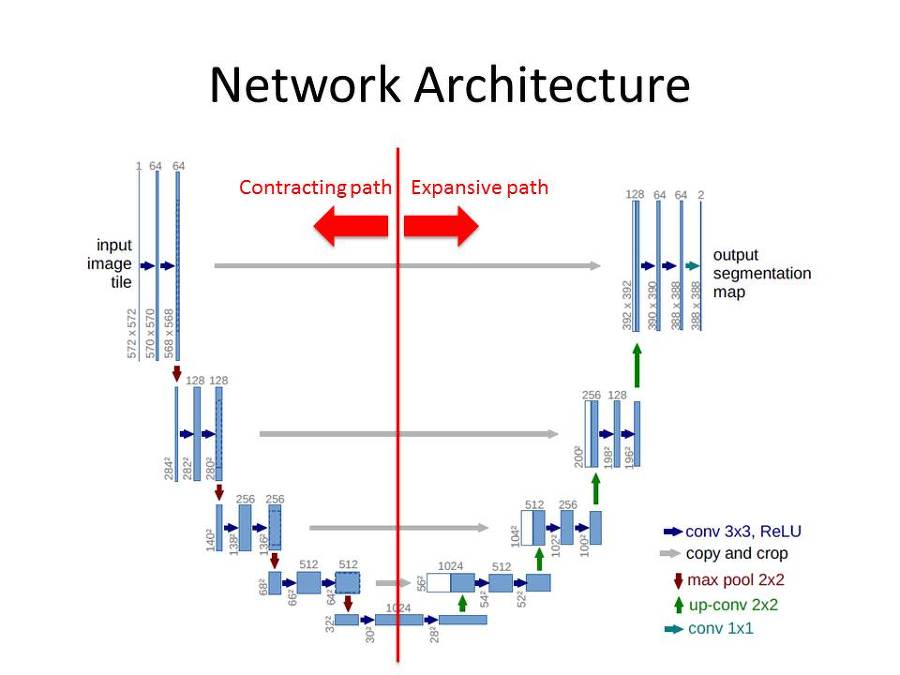</center>

In [4]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes:int=3,input_shape=(10,10),**kwargs):
        super(SimpleModel, self).__init__()
        
        ## Encoder
        self.conv1 = self.Encoder(num_classes, 32, 7, 3)
        self.conv2 = self.Encoder(32, 64, 3, 1)
        
        # Decoder
        self.upconv2 = self.Decoder(64, 32, 3, 1)
        self.upconv1 = self.Decoder(32*2, num_classes, 3, 1)

    def forward(self, x):

        # Downsample
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        
        # Upsample
        upconv2 = self.upconv2(conv2)
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def Encoder(self, in_channels, out_channels, kernel_size, padding):

        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )


    def Decoder(self, in_channels, out_channels, kernel_size, padding):
        return nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
        )

Do not forget to use Tensorboard. It really helps.

# Question 2

Adapt your previously coded function ```train function``` for the current lab. Do not forget to select an appropriate ```loss``` function for the task. 

# Question 3

We want to be able to compute the accuracy on the ```validation``` split at the end of each epoch. Adapt question 2 such that we can do so. 
Do not forget to put your model in ```eval``` when computing your predictions and put it back in ```train``` after.

# Question 4

Is ```accuracy```  a good metric for the task at hand? Why? ```hint:``` Try to compare your results ```qualitatively``` and ```quantitatively```.

# Question 5

If you answered in a negative way for Question 5, which would be a better metric for the task? Can you use it for the current lab?

# Question 6

As we did for the previous lab, go through the transformation documention. Did you find any that helps? Why?

# Question 7

What is the best result you can achieve? You are free to adapt both the network and hyperparameters. Compare results in the three splits.